In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import math
from functools import partial
from open3d.t.geometry import TriangleMesh

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataname = "/home/chris/Code/PointClouds/data/ply/CircularVentilationGrateExtraCleanedFull.ply"
pcd = o3d.io.read_point_cloud(dataname)

In [3]:
pcd_center = pcd.get_center()
pcd.translate(-pcd_center)

PointCloud with 2116800 points.

In [4]:
#Outlier removal

nn = 16
std_multiplier = 10

filtered_pcd = pcd.remove_statistical_outlier(nn,std_multiplier)
outliers = pcd.select_by_index(filtered_pcd[1], invert = True)
outliers.paint_uniform_color([1,0,0])
filtered_pcd = filtered_pcd[0]

#o3d.visualization.draw_geometries([filtered_pcd, outliers])

In [5]:
#Downsampling

voxel_size = 0.01
pcd_downsampled = filtered_pcd.voxel_down_sample(voxel_size=voxel_size)
print(f'number of points: {len(pcd_downsampled.points)}')
#o3d.visualization.draw_geometries([pcd_downsampled])

number of points: 2114266


In [6]:
#Extract normals

nn_distance = np.mean([pcd.compute_nearest_neighbor_distance()])
radius_normals = nn_distance*4

pcd_downsampled.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd_downsampled.paint_uniform_color([0.6,0.6,0.6])
#o3d.visualization.draw_geometries([pcd_downsampled, outliers])

PointCloud with 2114266 points.

In [7]:
# Extracting and Setting Parameters

front =  [-0.47452876114542436, 0.57451207113849134, -0.66690204300328082]
lookat = [-6.3976792217838847, 20.927374714553928, 18.659758576873813]
up =  [-0.056918726368614558, -0.77607794684805009, -0.62806311705487861]
zoom = 0.69999999999999996

pcd = pcd_downsampled

#o3d.visualization.draw_geometries([pcd_downsampled], zoom=zoom, front=front, lookat=lookat, up=up)

Run 1/10 started. Number of inliers: 1861042. Done
Run 2/10 started. Number of inliers: 45219. Done
Run 3/10 started. Number of inliers: 42965. Done
Run 4/10 started. Number of inliers: 41834. Done
Run 5/10 started. Number of inliers: 41849. Done
Run 6/10 started. Number of inliers: 39245. Done
Run 7/10 started. Number of inliers: 38875. Done
Run 8/10 started. Number of inliers: 2087. Done
Run 9/10 started. Number of inliers: 522. Done
Run 10/10 started. Number of inliers: 345. Done


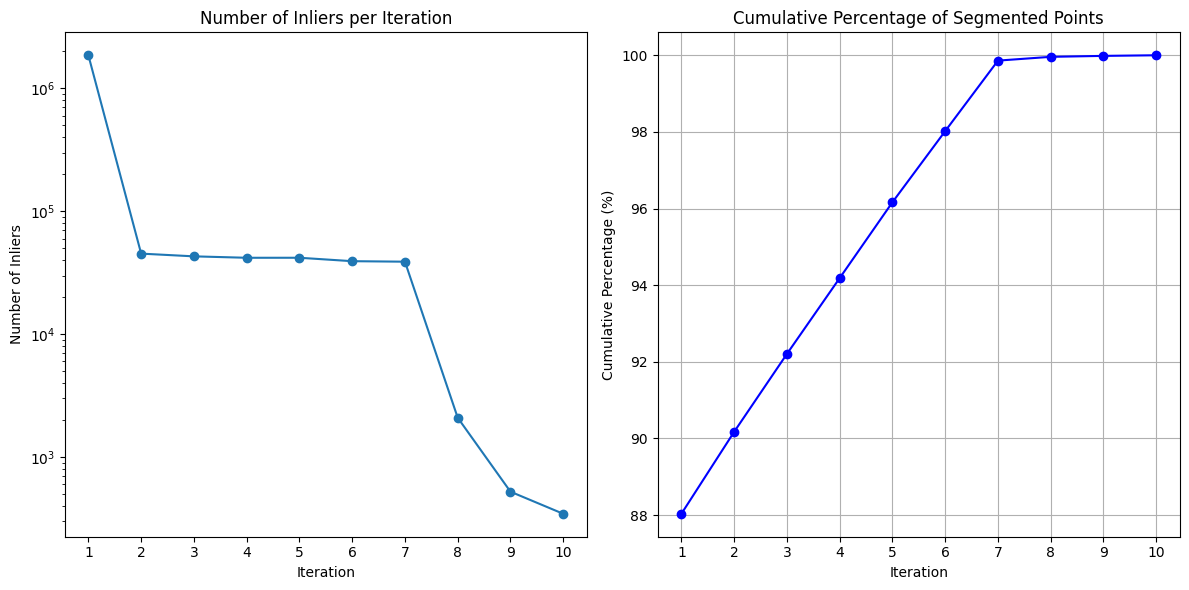

In [8]:
# RansacAnalysis

pt_to_plane_dist = 0.41
max_iterations = 10  # We will track the first 10 iterations

iterations = np.arange(10)
segment_models = {}
segments = {}
num_inliers_list = []
residuals_list = []
rest = pcd

for i in range(max_iterations):
    if len(rest.points) == 0:
        break

    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(
        distance_threshold=pt_to_plane_dist,
        ransac_n=3,
        num_iterations=50000
    )
    segments[i] = rest.select_by_index(inliers)
    num_inliers = len(segments[i].points)
    print(f'Run {i+1}/{max_iterations} started. Number of inliers: {num_inliers}. ', end='')
    num_inliers_list.append(num_inliers)
    
    # Fit quality metric: ratio of inliers to the total number of points remaining
    [a, b, c, d] = segment_models[i]
    inlier_points = np.asarray(segments[i].points)
    distances = np.abs(a * inlier_points[:, 0] + b * inlier_points[:, 1] + c * inlier_points[:, 2] + d) / np.sqrt(a**2 + b**2 + c**2)

    mean_residual = np.mean(distances)
    residuals_list.append(mean_residual)

    rest = rest.select_by_index(inliers, invert=True)

    segments[i].paint_uniform_color(list(colors[:3]))
    
    print('Done')

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(iterations+1, num_inliers_list, marker='o')
plt.xlabel('Iteration')
plt.xticks(iterations+1)
plt.ylabel('Number of Inliers')
plt.yscale('log')
plt.title('Number of Inliers per Iteration')

total_points = sum(num_inliers_list)  # Total number of points in your original point cloud
cumulative_inliers = np.cumsum(num_inliers_list)
cumulative_percentage = cumulative_inliers / total_points * 100  # Convert to percentage

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_percentage) + 1), cumulative_percentage, marker='o', color='blue')
plt.xlabel('Iteration')
plt.xticks(iterations+1)
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Percentage of Segmented Points')
plt.grid(True)

plt.tight_layout()
plt.show()

# o3d.visualization.draw_geometries(
#         [segments[i] for i in range(len(segments))] + [rest],
#         zoom=zoom, front=front, lookat=lookat, up=up
#     )

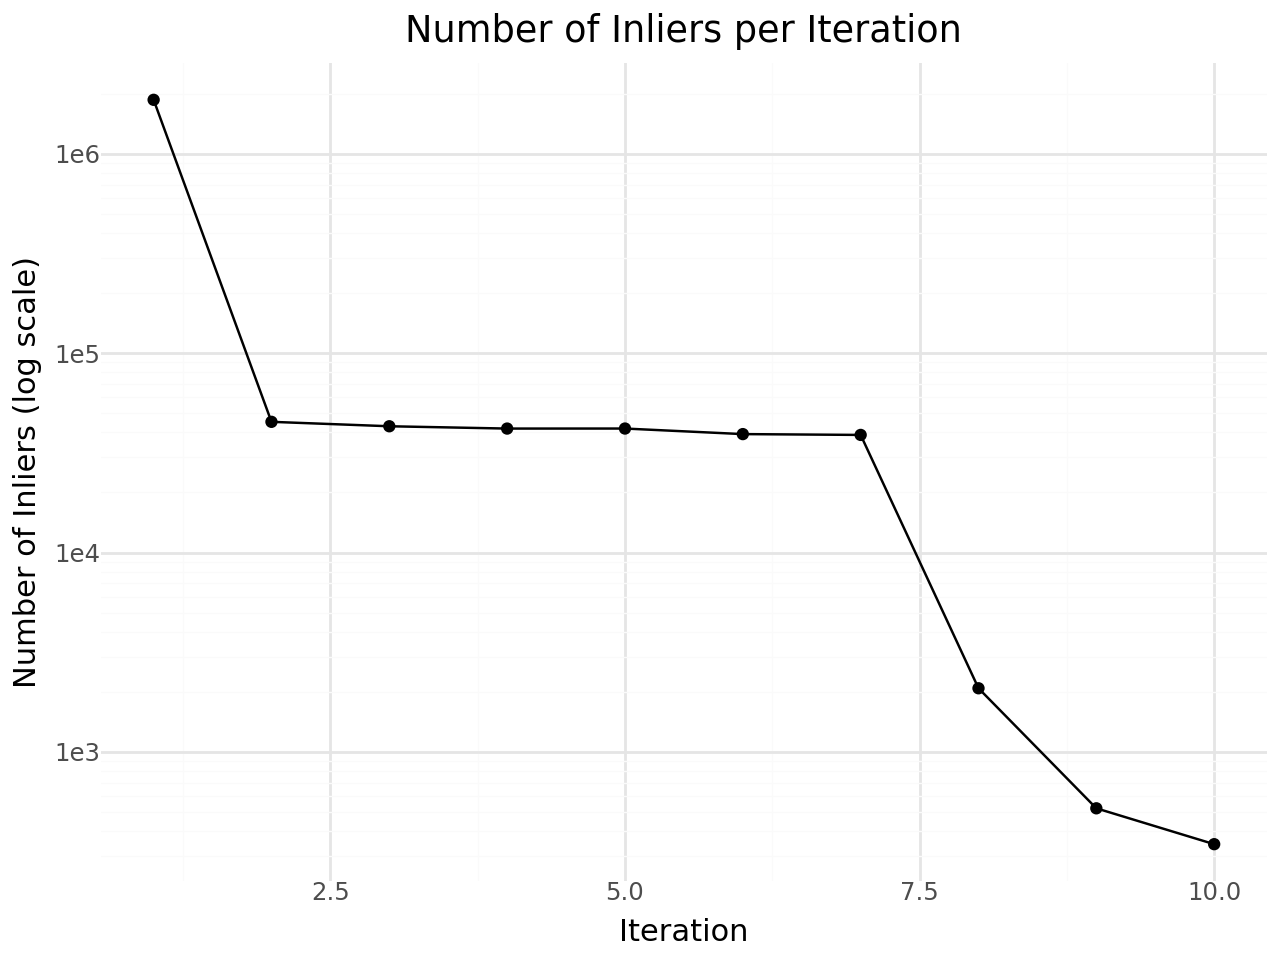

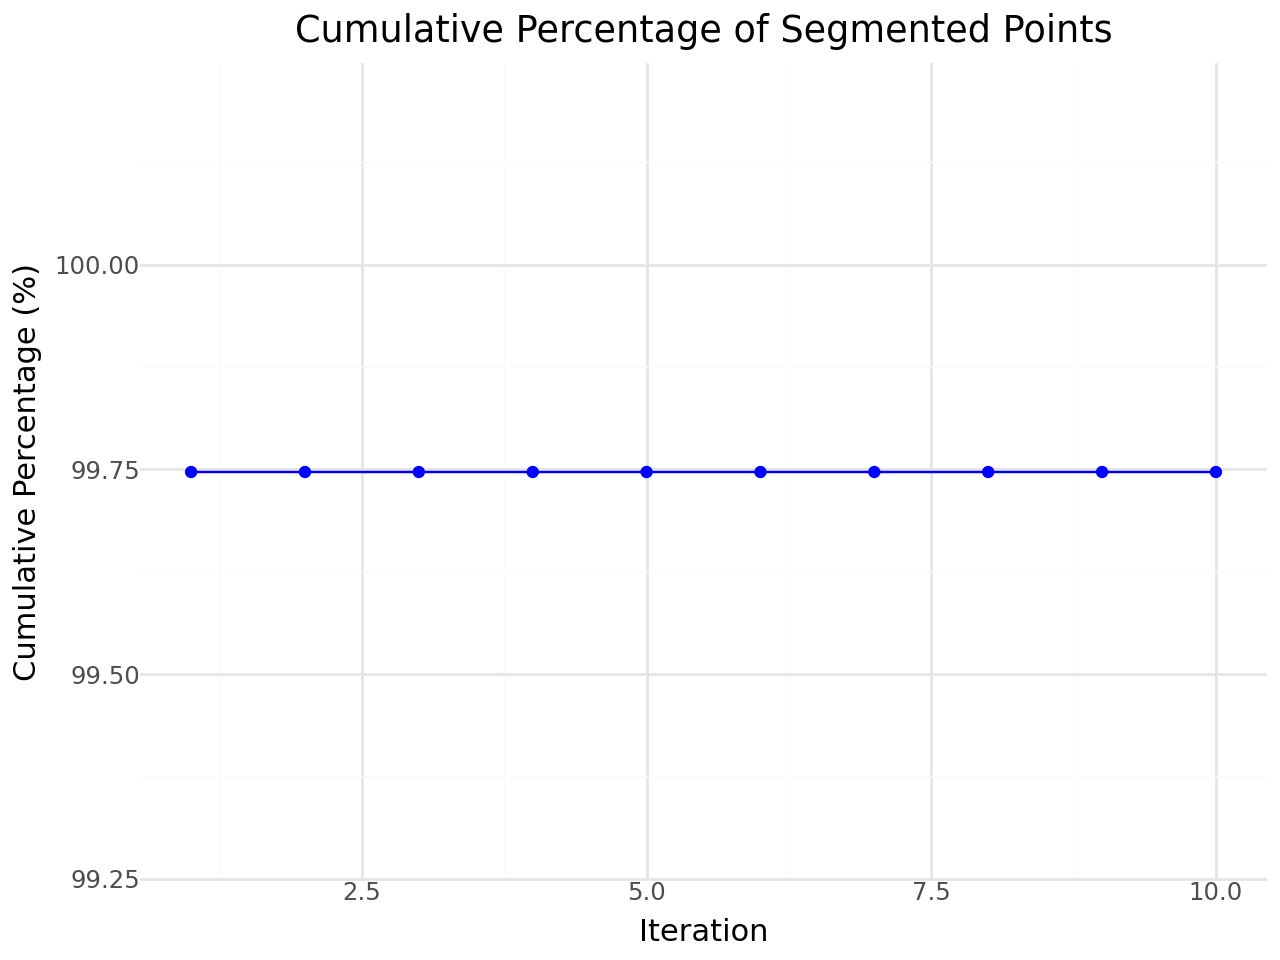

In [ ]:
import pandas as pd
import numpy as np


iterations = np.arange(1, 11)
df = pd.DataFrame({
    "Iteration": iterations,
    "NumInliers": num_inliers_list,
    "CumulativePercentage": cumulative_percentage
})

from plotnine import *
from plotnine import options

# Fix DPI and avoid blurry rendering in Jupyter
options.figure_size = (6, 4)  # width, height in inches
options.dpi = 100

plot1 = (
    ggplot(df, aes(x="Iteration", y="NumInliers")) +
    geom_line() +
    geom_point() +
    scale_y_log10() +
    labs(title="Number of Inliers per Iteration",
         x="Iteration", y="Number of Inliers (log scale)") +
    theme_minimal()
)

plot2 = (
    ggplot(df, aes(x="Iteration", y="CumulativePercentage")) +
    geom_line(color="blue") +
    geom_point(color="blue") +
    labs(title="Cumulative Percentage of Segmented Points",
         x="Iteration", y="Cumulative Percentage (%)") +
    theme_minimal()
)

plot1.show()
plot2.show()

In [9]:
pt_to_plane_dist = 0.41
max_iterations = 20

segment_models = {}
segments = {}
plane_inliers = {}
rest = pcd

for i in range(max_iterations):
    if len(rest.points) < 100:
        break

    segment_models[i], inliers = rest.segment_plane(
        distance_threshold=pt_to_plane_dist,
        ransac_n=3,
        num_iterations=50000
    )

    segments[i] = rest.select_by_index(inliers)
    number_of_inliers = len(segments[i].points)
    plane_inliers[i] = number_of_inliers

    rest = rest.select_by_index(inliers, invert=True)

plane_inliers = {k: v for k, v in sorted(plane_inliers.items(), key=lambda item: item[1], reverse=True)}
print(f'plane_inliers: {plane_inliers}')

drop_rate = 0.2
current_level = 1
current_level_value = plane_inliers[0]
last_plane_key = 0
it = 0
for key, value in plane_inliers.items():
    if value < drop_rate*current_level_value:
        cumulative_percentage = np.sum(list(plane_inliers.values())[:key]) / len(pcd.points) * 100
        if cumulative_percentage < 99:
            print(f'Dropping level from value {current_level_value} to {value} at level {current_level}')
            current_level += 1
            current_level_value = value
        else:
            print(f'Reached 99% of points at level {current_level}')
            number_of_planes = it
            break
    it += 1

print(f'Number of levels: {current_level}')
print(f'Number of planes: {it}')
    

plane_inliers: {0: 1853606, 1: 46227, 2: 44700, 3: 43439, 4: 42362, 5: 40150, 6: 38430, 7: 4167, 8: 589, 9: 404, 10: 97}
Dropping level from value 1853606 to 46227 at level 1
Reached 99% of points at level 2
Number of levels: 2
Number of planes: 7
